# Iris Flower Classification with Scikit-Learn and Hopsworks

In this notebook we will, 

1. Import libraries and connect to Hopsworks Feature Store
2. Load the iris Flower dataset
3. Create a feature group and upload to the feature store
4. Create a feature view from the feature group
5. Create a training dataset
6. Train a model using SkLearn
7. Save the trained model to Hopsworks
8. Launch a serving instance.
9. Model deployment in Hopsworks
10. Send a prediction request to the served model
11. Try out your Model Interactively with a Gradio UI 


In [ ]:
!pip install -U hopsworks --quiet

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib
import numpy as np
import time
import json
import random
import hopsworks
import pandas as pd
from sklearn import preprocessing

## <span style="color:#ff5f27;"> 💽 Loading the Data </span>

In [2]:
iris_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/iris.csv")
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [3]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

We can save two feature groups (hive tables), one called `iris_features` that contains the iris features and the corresponding numeric label, and another feature group called `iris_labels_lookup` for converting the numeric iris label back to categorical.

**Note**: To be able to run the feature store code, you first have to enable the Feature Store Service in your project. To do this, go to the "Settings" tab in your project, select the feature store service and click "Save". 

In [4]:
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/3235


Connected. Call `.close()` to terminate connection gracefully.


In [6]:
iris_fg = fs.get_or_create_feature_group(name="iris",
                                         version=1,
                                         primary_key=["sepal_length","sepal_width","petal_length","petal_width"],
                                         description="Iris flower dataset")
iris_fg.insert(iris_df)

Uploading Dataframe: 0.00% |          | Rows 0/150 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3235/jobs/named/iris_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x154adef4580>, None)

## <span style="color:#ff5f27;"> ⚙️ Feature View Creation </span>

Feature views are used to read features for training and inference.
If the feature view already exists, get it. If not, an exception is thrown, and we create the feature view.

In [7]:
try:
    feature_view = fs.get_feature_view(name="iris", version=1)
except:
    # Feature Selection
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris",
                                      version=1,
                                      description="Read from Iris flower dataset",
                                      labels=["variety"],
                                      query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/3235/fs/3182/fv/iris/version/1


## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

Training dataset is created using `fs.create_train_validation_test_split()` method.

* `X_train` is the train set features
* `X_val` is the validation set features
* `X_test` is the test set features
* `Y_train` is the train set labels
* `Y_val` is the validation set labels
* `Y_test` is the test set labels

In [8]:
td_version, td_job = feature_view.create_train_validation_test_split(
    description = 'iris tutorial',
    data_format = 'csv',
    validation_size = 0.2,
    test_size = 0.1,
    write_options = {'wait_for_job': True},
    coalesce = True,
)

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3235/jobs/named/iris_1_1_create_fv_td_01122022114021/executions


In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.get_train_validation_test_split(td_version)

## <span style="color:#ff5f27;"> 🧬 Modeling</span>

Train the XGBoost Classifier model.

In [34]:
import xgboost as xgb
from sklearn import preprocessing

# Use a label encoder to map the categorical labels to numbers.
le = preprocessing.LabelEncoder()
y_train_encoded=le.fit_transform(y_train['variety'])
y_test_encoded = le.transform(y_test['variety'])


model = xgb.XGBClassifier()

model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

### Evalute model performance

Compute the MSE of the model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

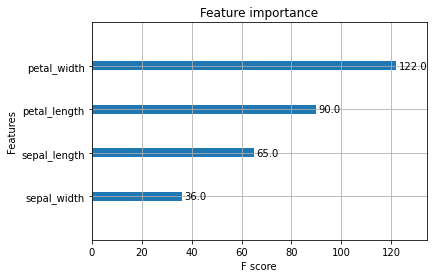

In [36]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10, importance_type='weight')

In [37]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test_encoded, y_pred)

metrics = {
    "mse" : mse
}
print(metrics)

{'mse': 0.0}


In [38]:
y_test_encoded

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

In [39]:
y_pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
      dtype=int64)

## <span style="color:#ff5f27;">📝 Register model</span>

One of the features in Hopsworks is the model registry. This is where we can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

Save the following objects as .json files locally to a directory that will be uploaded later to the model registry:

 * the model object, **model** saved as iris_xgboost_model.json
 * the label encoder object, **le** saved as iris_encoder.json, so that we can reconstruct categorical names 
    from the encoded predictions (numbers) 
    
The model input schema is the same set of features as in the *X_train* DataFrame.

The model output schema is the same label as in the *y_train_encoded* array.

Finally, lazily create the model that will be register, including all files (artifacts) in the directory (containing the pickled label encoder object and the pickled model object), the model's input/output schema, and a sample input row (**input_example**). The model registry is the **mr** object, and for our Scikit-Learn model, we create a model of type Python with **mr.python.create_model()**. For TensorFlow, there is *mr.tensorflow.create_model()*.

In [44]:
import joblib
import os

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

    
model.save_model(model_dir + '/iris_xgboost_model.json')
joblib.dump(le, model_dir + '/iris_encoder.json')

['iris_model/iris_encoder.json']

In [45]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [46]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

iris_model = mr.python.create_model(
    name="iris_xgboost_model", 
    metrics=metrics,
    model_schema=model_schema,
    input_example=X_train.sample(), 
    description="Iris Flower Predictor")

iris_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/3235/models/iris_xgboost_model/1


Model(name: 'iris_xgboost_model', version: 1)

### <span style="color:#ff5f27;">📎 Predictor script for Python models</span>


Scikit-learn and XGBoost models are deployed as Python models, in which case you need to provide a **Predict** class that implements the **predict** method. The **predict()** method invokes the model on the inputs and returns the prediction as a list.

The **init()** method is run when the predictor is loaded into memory, loading the model from the local directory it is materialized to, *ARTIFACT_FILES_PATH*.

The directive "%%writefile" writes out the cell before to the given Python file. We will use the **iris_predictor.py** file to create a deployment for our model. 

In [61]:
%%writefile predict_example.py

import xgboost as xgb
import os


class Predict(object):
    
    def __init__(self):
        # NOTE: env var ARTIFACT_FILES_PATH has the local path to the model artifact files      
        self.model = xgb.XGBClassifier()
        self.model.load_model(os.environ["ARTIFACT_FILES_PATH"] + "/iris_xgboost_model.json")


    def predict(self, inputs):
        """ Serves a prediction request from a trained model"""
        return self.model.predict(inputs).tolist()

Writing predict_example.py


## <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> 🚀 Model Deployment</a>

Provide the predictor script because it is a Python model (Scikit-Learn)

In [62]:
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/483 elapsed<00:00 remaining<?

In [68]:
predictor_script_path

'/Projects/test2_roman/Models/predict_example.py'

In [67]:
ms = project.get_model_serving()
try:
    deployment = ms.get_deployment("irisdeployed")
except:
    deployment = iris_model.deploy(name="irisdeployed",
                                   script_file=predictor_script_path,  
                                   model_server="PYTHON", 
                                   serving_tool="KSERVE")

print("Deployment: " + deployment.name)
deployment.describe()

Connected. Call `.close()` to terminate connection gracefully.


RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/3235/serving). Server response: 
HTTP code: 400, HTTP reason: Bad Request, error code: 240017, error msg: Model path does not have a valid file structure, user msg: Model path requires either a python script or model file (i.e., joblib or pickle files)

### The deployment has now been registered. However, to start it you need to run:

In [ ]:
state = deployment.get_state()

if state.status != "Running":
    deployment.start()
    deployment.describe()
else:
    print("Deployment already running")

## <span style='color:#ff5f27'>🔮 Predicting using deployment</span>

In [ ]:
test_data = list(iris_model.input_example)

data = {"instances" : [test_data]}
res = deployment.predict(data)
print(test_data)
print(le.inverse_transform([res["predictions"][0]]))

## <span style="color:#ff5f27;"> 👾 Try out your Model Interactively </span> 


We will build a user interface with Gradio to allow you to enter the 4 feature values (sepal length/width and petal length/width), producing a prediction of the type of iris flower.

First, we have to install the gradio library.

In [ ]:
!pip install gradio --quiet
!pip install typing-extensions==4.3.0

### Run Gradio

Start the Gradio UI. Users enter the 4 feature values and a prediction is returned. We use the label encoder object to transform the number returned to the categorical value (stringified name of the Iris Flower).

In [ ]:
import gradio as gr


def iris(sl, sw, pl, pw):
    list_inputs = []
    list_inputs.append(sl)
    list_inputs.append(sw)
    list_inputs.append(pl)
    list_inputs.append(pw)
    data = {
        "instances": [list_inputs]
    }
    res = deployment.predict(data)
    # Convert the numerical representation of the label back to it's original iris flower name.
    return le.inverse_transform([res["predictions"][0]])[0]

demo = gr.Interface(
    fn=iris,
    title="Iris Flower Predictive Analytics",
    description="Experiment with sepal/petal lengths/widths to predict which flower it is.",
    allow_flagging="never",
    inputs=[
        gr.inputs.Number(default=1.0, label="sepal length (cm)"),
        gr.inputs.Number(default=1.0, label="sepal width (cm)"),
        gr.inputs.Number(default=1.0, label="petal length (cm)"),
        gr.inputs.Number(default=1.0, label="petal width (cm)"),
        ],
    outputs="text")

demo.launch(share=True)